##  Room_Match

Cupid API’s Room Match – Hotel Room Matching via ML & NLP

###  Objective: Multilingual Room Matching with Fuzzy Logic and XGBoost

Build a machine learning API similar to the Cupid API’s Room Match feature.  
The API should handle POST requests and return sample request/response payloads in a similar  
format to the Cupid Room Match API. Provide a detailed explanation of your development process,  
including how you collect and process data, develop models, and scale the system.

---

###  Pipeline Overview

This project builds a **multilingual, fuzzy logic–based machine learning pipeline**  
for **matching hotel room listings** between suppliers and a reference dataset.  
It supports **multiple and mixed languages** (e.g., English, Korean, Arabic) using  
`fastText` and `rapidfuzz`, followed by a binary classification model using **XGBoost**.



###  Exploratory Data Analysis (EDA)

-  Dropped rows with missing `supplier_room_name` or `room_name`
-  Verified data types: `room_id`, `core_room_id`, `hotel_id`, etc.
-  Removed rows with `NaN`, empty strings, or duplicate entries



###  Data Preparation Strategy

### Candidate Filtering by ID

We first narrow down potential matches using:

- `lp_id` (landing page IDs for room matching is weak signal)
- `core_hotel_id` and `hotel_id`
- `core_room_id`, `supplier_room_id`, and `room_id`

➡ This gives a **small candidate set** for each supplier room.



### Room Name Matching

Using multilingual support:

- **Language Detection**: fastText `lid.176.bin`
- **Fuzzy Token Matching**: `rapidfuzz.partial_ratio`  
  (after lowercasing, stripping accents, and removing punctuation)

 Handles **mixed-language names** like:  
`"Deluxe Room (디럭스 패밀리 트윈)"`



###  Matching Logic

Each candidate pair is labeled based on:

| Condition                           | Feature        |
|------------------------------------|----------------|
| `hotel_id`, `room_id` match | Feature flags |
| `fuzzy_score >= 0.85`              | Considered a match |
| Any strong match present           | `label = 1`    |

```python
label = int(fuzzy_score >= 0.85 or id_match)


In [1]:
# check python version
!python --version

Python 3.10.12


In [2]:
#### colab installation:
!pip install pandas numpy sentence_transformers tqdm rapidfuzz fasttext seaborn matplotlib statsmodels scikit-learn xgboost optuna tensorflow torch joblib ace_tools_open

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 69.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
import re
from tqdm import tqdm
from collections import Counter
from collections import defaultdict
from rapidfuzz.fuzz import partial_ratio
import fasttext
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, classification_report
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import accuracy_score 
import ace_tools_open as tools
import joblib
import gc

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
df_rooms = pd.read_csv('/kaggle/input/room-match/updated_core_rooms.csv')
df_ref = pd.read_csv('/kaggle/input/room-match/referance_rooms-1737378184366.csv')

In [5]:
df_rooms

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
0,1,506732,lp7bb6c,200979491,Expedia,Superior Double Room
1,2,509236,lp7c534,200998017,Expedia,"Deluxe Room, Balcony"
2,3,516326,lp7e0e6,201144757,Expedia,Female Dormitory- 3 Beds
3,4,495330,lp78ee2,201028863,Expedia,"Standard Apartment, 2 Bedrooms (6 people)"
4,5,970167,lpecdb7,218116045,Expedia,"Traditional Cottage, 2 Bedrooms, Harbor View"
...,...,...,...,...,...,...
2869051,2912439,193359,lp2f34f,323872346,Expedia,"Deluxe Room, 1 King Bed with Sofa bed"
2869052,2912440,143473,lp23071,230770971,Expedia,Ocean Bay Pool Room
2869053,2912441,1701692958,lp656dc61e,322166812,Expedia,8 Berth Luxury Caravan
2869054,2912442,143473,lp23071,315521742,Expedia,Beach Room


In [6]:
df_ref

,hotel_id,lp_id,room_id,room_name
0,13484077,lp23e8ef,1142730702,Double or Twin Room
1,13487663,lp6554de34,1141927122,House
2,13462809,lp6556c3dc,1142722063,Room
3,13530116,lp6555450b,1141968275,Triple Room
4,13530071,lp6557a92c,1142513784,Apartment
...,...,...,...,...
99995,21684,lp6561b025,2168409,Two-Bedroom Suite
99996,21684,lp6561b025,2168411,Deluxe Triple Room
99997,21684,lp6561b025,2168412,Deluxe Queen Room with Two Queen Beds
99998,21684,lp6561b025,2168413,Classic Quadruple Room


In [7]:
print(df_rooms.info())
print(df_ref.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869056 entries, 0 to 2869055
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   core_room_id        int64 
 1   core_hotel_id       int64 
 2   lp_id               object
 3   supplier_room_id    int64 
 4   supplier_name       object
 5   supplier_room_name  object
dtypes: int64(3), object(3)
memory usage: 131.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   hotel_id   100000 non-null  int64 
 1   lp_id      100000 non-null  object
 2   room_id    100000 non-null  int64 
 3   room_name  100000 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.1+ MB
None


In [8]:
print(" NaN values in df_rooms:")
print(df_rooms.isna().sum())

print("\n NaN values in df_ref:")
print(df_ref.isna().sum())


 NaN values in df_rooms:
core_room_id          0
core_hotel_id         0
lp_id                 0
supplier_room_id      0
supplier_name         0
supplier_room_name    1
dtype: int64

 NaN values in df_ref:
hotel_id     0
lp_id        0
room_id      0
room_name    0
dtype: int64


In [9]:
df_rooms[df_rooms['supplier_room_name'].isna()]

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
1376206,1378719,970619,lpecf7b,220527262,Expedia,NaN


In [10]:
df_rooms_cleaned = df_rooms.dropna(subset=['supplier_room_name'])

In [11]:
df_rooms = df_rooms_cleaned.copy()

In [12]:
print(" Empty string counts in df_rooms:")
print((df_rooms.select_dtypes(include='object') == '').sum())

print("\n Empty string counts in df_ref:")
print((df_ref.select_dtypes(include='object') == '').sum())

 Empty string counts in df_rooms:
lp_id                 0
supplier_name         0
supplier_room_name    0
dtype: int64

 Empty string counts in df_ref:
lp_id        0
room_name    0
dtype: int64


Common lp_id count: 0        lp65554af2
1           lp370d1
2           lp6d266
3        lp65583a14
4        lp655458fe
            ...    
28633       lpa3892
28634    lp656bed24
28635       lpe259e
28636    lp6555c39d
28637    lp65581c16
Length: 28638, dtype: object
common hotel_id count: 0       364545
1       286722
2       720899
3      2201605
4       440327
        ...   
847     186352
848     188400
849     454643
850    2627579
851     600060
Length: 852, dtype: int64
Common room_id : 0      1429504
1      1429505
2        45058
3      1429506
4      1429507
        ...   
575     114683
576    2646012
577    1429501
578    1429502
579    1429503
Length: 580, dtype: int64
Common hotel_id count: 0      314329102
1      324035101
2      322947102
3      228316702
4      228316703
         ...    
99     216939502
100    216939503
101    216939504
102    202266104
103       114687
Length: 104, dtype: int64
Match Counts Summary:

lp_id: 28638
hotel_id (core_hotel_id): 852
core_ro

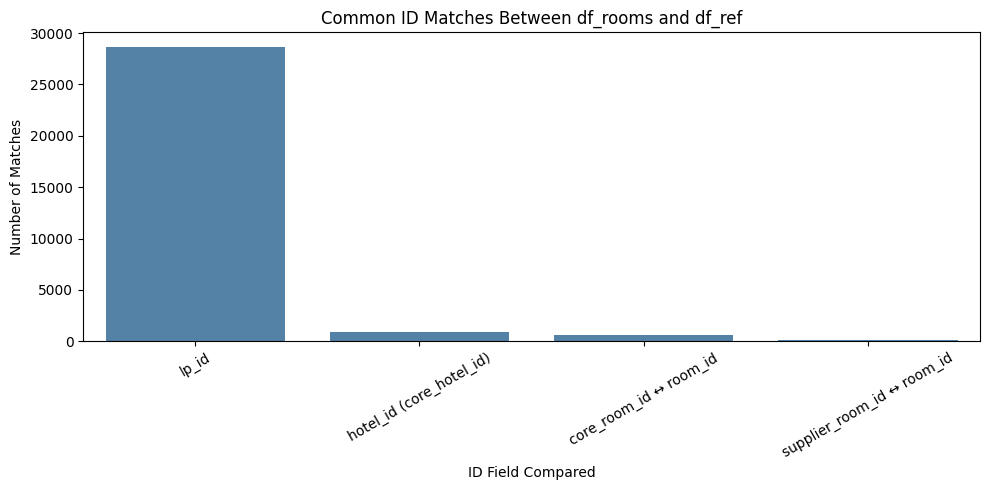

In [13]:
### looking for id matches
common_lp_ids = pd.Series(list(set(df_rooms['lp_id']) & set(df_ref['lp_id'])))
print(f"Common lp_id count: {common_lp_ids}")

common_hotel_ids = pd.Series(list(set(df_rooms['core_hotel_id']) & set(df_ref['hotel_id'])))
print(f"common hotel_id count: {common_hotel_ids}")

common_core_room_ids = pd.Series(list(set(df_rooms['core_room_id']) & set(df_ref['room_id'])))
print(f"Common room_id : {common_core_room_ids}")

common_supplier_room_ids = pd.Series(list(set(df_rooms['supplier_room_id']) & set(df_ref['room_id'])))
print(f"Common hotel_id count: {common_supplier_room_ids}")


# Count summary
match_counts = {
    'lp_id': len(common_lp_ids),
    'hotel_id (core_hotel_id)': len(common_hotel_ids),
    'core_room_id ↔ room_id': len(common_core_room_ids),
    'supplier_room_id ↔ room_id': len(common_supplier_room_ids)
}

# Print counts
print("Match Counts Summary:\n")
for k, v in match_counts.items():
    print(f"{k}: {v}")

# Convert to DataFrame for plotting
match_df = pd.DataFrame(list(match_counts.items()), columns=['ID Type', 'Match Count'])

# Barplot with no warning about palette
plt.figure(figsize=(10, 5))
sns.barplot(data=match_df, x='ID Type', y='Match Count', color='steelblue')  # use `color` instead of `palette`
plt.title("Common ID Matches Between df_rooms and df_ref")
plt.xlabel("ID Field Compared")
plt.ylabel("Number of Matches")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [14]:
# Load language detection model
# Download the model from https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
lang_model = fasttext.load_model('/kaggle/input/lid176/other/default/1/lid.176.bin')

# Language detection
def detect_lang(text):
    try:
        label, confidence = lang_model.predict(text.strip().replace('\n', ''))
        return label[0].replace('__label__', ''), confidence[0]
    except:
        return 'unknown', 0.0

# Detect language for supplier room names in df_rooms
df_rooms_langs = df_rooms['supplier_room_name'].dropna().apply(lambda x: detect_lang(x)[0])
rooms_lang_count = Counter(df_rooms_langs)

# Detect language for reference room names in df_ref
df_ref_langs = df_ref['room_name'].dropna().apply(lambda x: detect_lang(x)[0])
ref_lang_count = Counter(df_ref_langs)

# Display results
print("Language distribution in df_rooms (supplier room names):")
for lang, count in rooms_lang_count.most_common():
    print(f"{lang}: {count}")

print("\n Language distribution in df_ref (reference room names):")
for lang, count in ref_lang_count.most_common():
    print(f"{lang}: {count}")


Language distribution in df_rooms (supplier room names):
en: 2769588
it: 46120
fr: 12469
es: 10253
de: 9766
pt: 5996
ar: 4281
nl: 2326
ja: 1835
pl: 1059
ca: 538
sv: 471
id: 446
zh: 430
ceb: 379
tr: 343
fi: 263
ru: 255
hu: 204
eo: 164
ms: 157
no: 155
oc: 153
cs: 142
da: 113
gl: 109
eu: 101
fa: 97
uk: 80
hr: 66
ro: 58
sl: 46
la: 45
et: 43
vi: 40
th: 39
sr: 34
ko: 28
lt: 26
af: 21
sk: 21
mzn: 21
war: 18
fy: 17
sh: 14
cy: 13
az: 13
nds: 13
nn: 13
mk: 10
sq: 10
te: 9
jv: 8
br: 8
ur: 8
lv: 8
min: 7
bs: 6
als: 6
su: 6
bn: 5
ast: 5
tl: 5
vo: 4
jbo: 4
kw: 4
ml: 4
io: 4
tt: 3
mr: 3
el: 3
is: 3
ku: 3
ia: 3
sw: 3
mn: 3
my: 3
gd: 2
hy: 2
uz: 2
km: 2
pms: 2
kk: 2
hsb: 1
lb: 1
bg: 1
ie: 1
ga: 1
qu: 1
si: 1
cbk: 1
ta: 1
arz: 1
pam: 1
am: 1
rm: 1

 Language distribution in df_ref (reference room names):
en: 97479
it: 1354
fr: 372
es: 216
de: 213
pt: 104
nl: 58
ja: 27
zh: 16
ru: 15
sv: 14
id: 14
pl: 13
oc: 12
tr: 11
fi: 10
eo: 8
ca: 8
ceb: 8
fa: 7
ms: 7
hu: 5
eu: 3
cs: 3
uk: 3
ro: 3
bn: 2
da: 2
sl: 2
vi

####  Example checks

In [15]:
df_rooms[df_rooms['lp_id'] == 'lp74c8d']

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
1457761,1460274,478349,lp74c8d,200812670,Expedia,Deluxe Double Room
1463658,1466171,478349,lp74c8d,200812753,Expedia,Deluxe Twin Room
1468699,1471212,478349,lp74c8d,229805782,Expedia,"Premier Triple Room, 3 Twin Beds"
1471686,1474199,478349,lp74c8d,202118016,Expedia,Room (Randomly assigned upon check in)
1473832,1476345,478349,lp74c8d,200812756,Expedia,Premier Twin Room
1475011,1477524,478349,lp74c8d,202176354,Expedia,"Deluxe Twin Room, 2 Double Beds (디럭스 패밀리 트윈)"
2598140,2641528,478349,lp74c8d,322489962,Expedia,Premier Family Ondol Room


In [16]:
df_ref[df_ref['lp_id'] == 'lp74c8d']

,hotel_id,lp_id,room_id,room_name
64875,2544264,lp74c8d,254426401,Single Room with Balcony
64876,2544264,lp74c8d,254426402,Double Room with Balcony
64877,2544264,lp74c8d,254426403,Triple Room with Balcony
64878,2544264,lp74c8d,254426404,Quadruple Room with Balcony
64879,2544264,lp74c8d,254426414,Economy Double Room
64880,2544264,lp74c8d,254426415,Superior Family Room
64881,2544264,lp74c8d,254426416,Villa - Beach Front


In [17]:
df_rooms[df_rooms['lp_id'] == 'lp655835e3']

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
2350656,2394044,1700279779,lp655835e3,320662691,Expedia,إستديو ديلوكس
2354917,2398305,1700279779,lp655835e3,320662463,Expedia,غرفة مزدوجة


In [18]:
df_ref[df_ref['lp_id'] == 'lp655835e3']

,hotel_id,lp_id,room_id,room_name
74793,13463994,lp655835e3,1142451754,Deluxe Studio
74794,13463994,lp655835e3,1142451769,Double Room


In [19]:
df_rooms[df_rooms['core_hotel_id'] == 628660]

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
153,154,628660,lp997b4,201691711,Expedia,"Family House, 5 Bedrooms"


In [20]:
df_ref[df_ref['hotel_id'] == 628660]

,hotel_id,lp_id,room_id,room_name
65895,628660,lp71165,62866001,Double Room
65896,628660,lp71165,62866002,Twin Room
65897,628660,lp71165,62866003,Standard Triple Room
65898,628660,lp71165,62866005,Quadruple Room
65899,628660,lp71165,62866006,Triple Room with One Double Bed and One Single...
65900,628660,lp71165,62866009,Superior Double Room


In [21]:
df_rooms[df_rooms['core_room_id'] == 1429507]

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
1426994,1429507,674747,lpa4bbb,201881189,Expedia,Deluxe Room


In [22]:
df_ref[df_ref['room_id'] == 1429507]

,hotel_id,lp_id,room_id,room_name
62113,14295,lp4d7e4,1429507,Superior Three-Bedroom Apartment


In [23]:
df_rooms[df_rooms['supplier_room_id'] == 228316703]

,core_room_id,core_hotel_id,lp_id,supplier_room_id,supplier_name,supplier_room_name
866707,869220,1700065373,lp6554f05d,228316703,Expedia,Executive Room


In [24]:
df_ref[df_ref['room_id'] == 228316703]

,hotel_id,lp_id,room_id,room_name
90958,2283167,lp6564419b,228316703,Two-Bedroom Apartment


### Fasttext fuzzy score

In [25]:
### FastText Language Detection

def detect_lang(text):
    label, confidence = lang_model.predict(text.strip().replace('\n', ''))
    return label[0].replace('__label__', ''), confidence[0]

def lang_similarity(text1, text2):
    lang1, conf1 = detect_lang(text1)
    lang2, conf2 = detect_lang(text2)
    same_lang = lang1 == lang2
    return {
        'lang1': lang1, 'conf1': conf1,
        'lang2': lang2, 'conf2': conf2,
        'same_lang': same_lang
    }

# Example
print(lang_similarity("Deluxe Room (ディラックス ルーム)", "غرفة ديلوكس"))
print(lang_similarity("Deluxe Room", "Luxury Room"))


{'lang1': 'ja', 'conf1': 0.9707074165344238, 'lang2': 'ar', 'conf2': 0.9998712539672852, 'same_lang': False}
{'lang1': 'en', 'conf1': 0.43188002705574036, 'lang2': 'en', 'conf2': 0.5957378149032593, 'same_lang': True}


In [26]:
# Load language detection model
lang_model = fasttext.load_model('/kaggle/input/lid176/other/default/1/lid.176.bin')

# Language detection
def detect_lang(text):
    try:
        label, confidence = lang_model.predict(text.strip().replace('\n', ''))
        return label[0].replace('__label__', ''), confidence[0]
    except:
        return 'unknown', 0.0

# Normalize text
def normalize(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = unicodedata.normalize('NFD', text)
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')  # Remove accents
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip()

# Fuzzy match
def fast_match(name1, name2):
    return partial_ratio(normalize(name1), normalize(name2)) / 100.0

# Pre-bucket reference data
ref_buckets = defaultdict(list)
for ref in df_ref.itertuples(index=False):
    ref_buckets[f"lp_{ref.lp_id}"].append(ref)
    ref_buckets[f"h_{ref.hotel_id}"].append(ref)
    ref_buckets[f"rid_{ref.room_id}"].append(ref)

# Match generation loop
match_rows = []

for r in tqdm(df_rooms.itertuples(index=False), total=len(df_rooms), desc="Multilingual fuzzy matching"):

    if not isinstance(r.supplier_room_name, str):
        continue

    lang_supplier, conf_supplier = detect_lang(r.supplier_room_name)

    # Collect candidate refs
    candidates = (
        ref_buckets.get(f"lp_{r.lp_id}", []) +
        ref_buckets.get(f"h_{r.core_hotel_id}", []) +
        ref_buckets.get(f"rid_{r.core_room_id}", []) +
        ref_buckets.get(f"rid_{r.supplier_room_id}", [])
    )

    if not candidates:
        continue

    for ref in candidates:
        if not isinstance(ref.room_name, str):
            continue

        sim = fast_match(r.supplier_room_name, ref.room_name)
        lang_ref, conf_ref = detect_lang(ref.room_name)

        # Strict hotel match required
        hotel_match = int(r.core_hotel_id == ref.hotel_id)
        if not hotel_match:
            continue  # Skip this pair if hotel_id doesn't match

        lp_match = int(r.lp_id == ref.lp_id)
        room_match = int((r.core_room_id == ref.room_id) or (r.supplier_room_id == ref.room_id))

        id_match = (lp_match + hotel_match + room_match) > 0  # Still used for tracking

        match_rows.append({
            'core_room_id': r.core_room_id,
            'supplier_room_id': r.supplier_room_id,
            'ref_room_id': ref.room_id,
            'lp_id_match': lp_match,
            'hotel_id_match': hotel_match,
            'room_id_match': room_match,
            'fuzzy_score': sim,
            'label': int(sim >= 0.85),  # Only use fuzzy_score since hotel already matched
            'supplier_room_name': r.supplier_room_name,
            'ref_room_name': ref.room_name,
            'lang_supplier': lang_supplier,
            'lang_ref': lang_ref,
            'lang_conf_supplier': conf_supplier,
            'lang_conf_ref': conf_ref
        })

match_df_fz = pd.DataFrame(match_rows)
match_df_fz

Multilingual fuzzy matching: 100%|██████████| 2869055/2869055 [00:42<00:00, 68052.71it/s]


,core_room_id,supplier_room_id,ref_room_id,lp_id_match,hotel_id_match,room_id_match,fuzzy_score,label,supplier_room_name,ref_room_name,lang_supplier,lang_ref,lang_conf_supplier,lang_conf_ref
0,154,201691711,62866001,0,1,0,0.631579,0,"Family House, 5 Bedrooms",Double Room,en,en,0.887304,0.578559
1,154,201691711,62866002,0,1,0,0.571429,0,"Family House, 5 Bedrooms",Twin Room,en,en,0.887304,0.506434
2,154,201691711,62866003,0,1,0,0.424242,0,"Family House, 5 Bedrooms",Standard Triple Room,en,en,0.887304,0.474728
3,154,201691711,62866005,0,1,0,0.500000,0,"Family House, 5 Bedrooms",Quadruple Room,en,en,0.887304,0.349836
4,154,201691711,62866006,0,1,0,0.470588,0,"Family House, 5 Bedrooms",Triple Room with One Double Bed and One Single...,en,en,0.887304,0.746510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19522,2908148,229831617,46142002,0,1,0,0.333333,0,Family Suite,Deluxe King Room,en,en,0.786567,0.504640
19523,2908148,229831617,46142003,0,1,0,0.500000,0,Family Suite,Queen Room with Mobility/Hearing Access - Non-...,en,en,0.786567,0.891699
19524,2909752,322092320,36034302,0,1,0,0.500000,0,Garden Studio,One-Bedroom Apartment,en,en,0.425630,0.869660
19525,2909752,322092320,36034304,0,1,0,0.380952,0,Garden Studio,Double Room,en,en,0.425630,0.578559


In [27]:
print(match_df_fz['label'].value_counts())

label
0    19060
1      467
Name: count, dtype: int64


### Results of fuzzy score
#### fuzzy_score: 0.75
    label
    0    18267
    1     1260

#### fuzzy_score: 0.85
    label
    0    19060
    1      467

#### fuzzy_score: 0.95
    label
    0    19100
    1      427

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

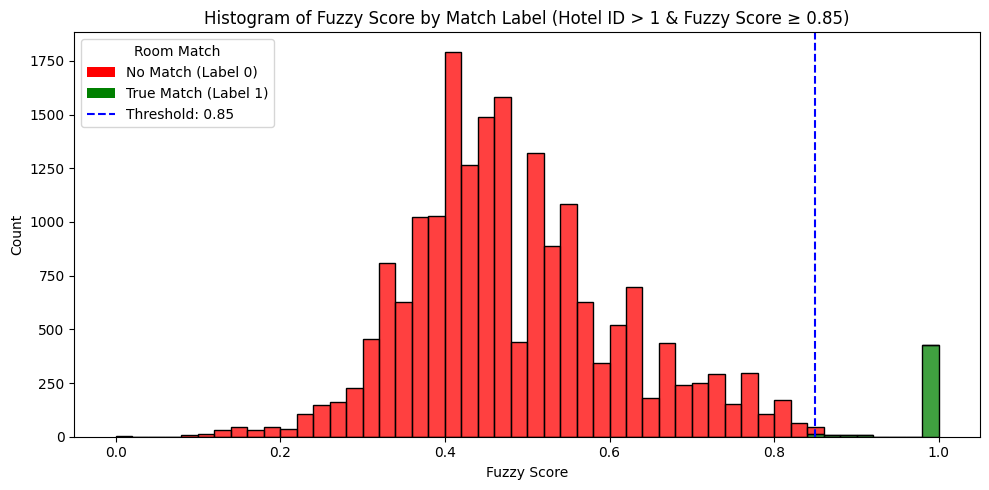

In [28]:
# Assuming match_df is already loaded with necessary columns
# We'll simulate a sample structure to demonstrate the visualizations

# Convert match_type to string if not already
match_df_fz['match_type'] = match_df_fz.apply(
    lambda x: f"{int((x['lp_id_match'] + x['hotel_id_match'] + x['room_id_match']) > 1)}_ID_" +
              f"{int(x['fuzzy_score'] >= 0.85)}_score",
    axis=1
)

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(
    data=match_df_fz, 
    x='fuzzy_score', 
    hue='label', 
    bins=50, 
    multiple='stack', 
    palette={0: 'red', 1: 'green'}, 
    stat='count'
)

# Add threshold line
plt.axvline(0.85, color='blue', linestyle='--', label='Threshold: 0.85')

# Customize plot
plt.title("Histogram of Fuzzy Score by Match Label (Hotel ID > 1 & Fuzzy Score ≥ 0.85)")
plt.xlabel("Fuzzy Score")
plt.ylabel("Count")

# Custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='No Match (Label 0)'),
    Patch(facecolor='green', label='True Match (Label 1)'),
    Line2D([0], [0], color='blue', linestyle='--', label='Threshold: 0.85')
]
plt.legend(handles=legend_elements, title="Room Match")

plt.tight_layout()
plt.show()


match_type
010    19527
Name: count, dtype: int64


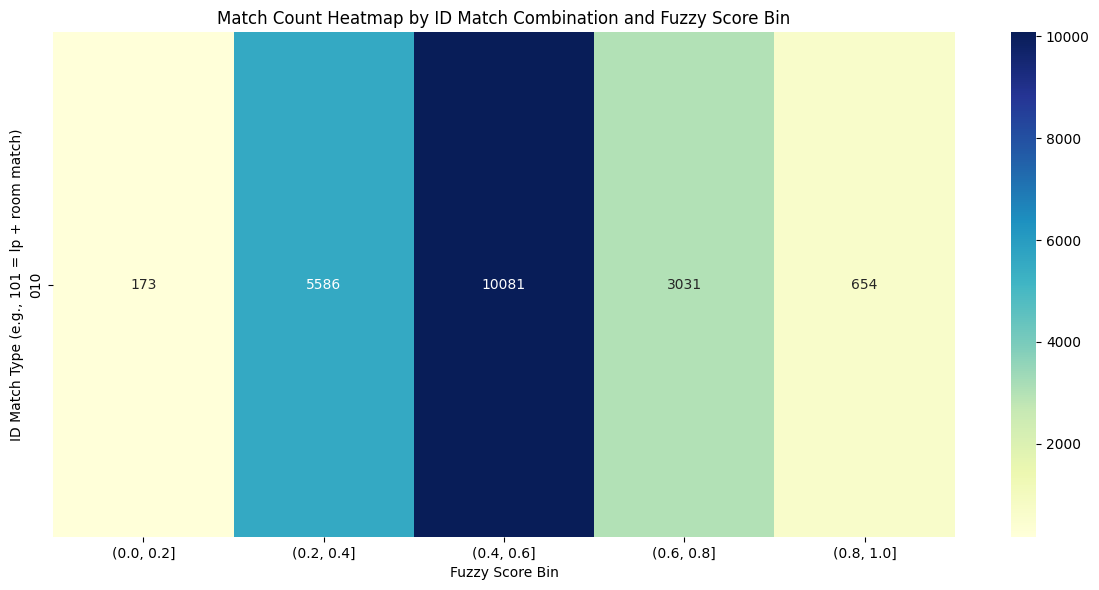

In [29]:
# Heatmap
# Make match_type a string like '100', '011', etc.
match_df_fz['match_type'] = match_df_fz.apply(
    lambda x: f"{x['lp_id_match']}{x['hotel_id_match']}{x['room_id_match']}", axis=1
)

# Count occurrences
match_type_counts = match_df_fz['match_type'].value_counts().sort_index()
print(match_type_counts)

match_df_fz['fuzzy_bin'] = pd.cut(match_df_fz['fuzzy_score'], bins=np.linspace(0, 1, 6))
heatmap_data = match_df_fz.groupby(['match_type', 'fuzzy_bin'], observed=True).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Match Count Heatmap by ID Match Combination and Fuzzy Score Bin")
plt.xlabel("Fuzzy Score Bin")
plt.ylabel("ID Match Type (e.g., 101 = lp + room match)")
plt.tight_layout()
plt.show()


### Sentence Transformer

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
model = SentenceTransformer("intfloat/multilingual-e5-base", device=device)
model.save("local_model_folder")

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/179k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [31]:
# Load the multilingual SBERT model
#model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
model = SentenceTransformer("./local_model_folder")

# Original mixed-language room name
#room1 = "Deluxe Twin Room, 2 Double Beds (디럭스 패밀리 트윈)"
room1 = "غرفة ديلوكس"
#room1 = "Deluxe Room"

# Translated version of the Korean room name
#room2_translated = "Deluxe Twin Room with two double beds"
room2_translated = "Deluxe Room (ディラックス ルーム)"
#room2_translated = "Luxury Room"

# Encode both
embedding1 = model.encode(room1, convert_to_tensor=True)
embedding2 = model.encode(room2_translated, convert_to_tensor=True)

# Compute similarity
similarity = util.cos_sim(embedding1, embedding2).item()
print(f"Translated similarity: {similarity:.4f}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Translated similarity: 0.9050


In [32]:
# =========================
# 1️ Device and Model
# Load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
model = SentenceTransformer("intfloat/multilingual-e5-base", device=device)

# =========================
# 2️ Normalize for encoding
# =========================
def normalize(text):
    text = text.lower()
    text = unicodedata.normalize('NFD', text)
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')
    text = re.sub(r'[^\w\s]', '', text)       # Remove punctuations
    text = re.sub(r'\d+pax|\d+beds?', '', text)  # Remove non-name tokens
    text = re.sub(r'\s+', ' ', text)          # Collapse whitespace
    return text.strip()

# =========================
# 3️ Encode reference data
# =========================
df_ref = df_ref.dropna(subset=['room_name']).copy()
df_ref['normalized_room_name'] = df_ref['room_name'].apply(normalize)

ref_embeddings = model.encode(
    df_ref['normalized_room_name'].tolist(),
    batch_size=4,
    convert_to_tensor=True,
    device=device,
    normalize_embeddings=True
).cpu().numpy().tolist()

df_ref['embedding'] = ref_embeddings

# =========================
# 4️ Create Buckets
# =========================
ref_buckets = defaultdict(list)
for ref in tqdm(df_ref.itertuples(index=False), total=len(df_ref), desc="Indexing reference buckets"):
    ref_buckets[f"lp_{ref.lp_id}"].append(ref)
    ref_buckets[f"h_{ref.hotel_id}"].append(ref)
    ref_buckets[f"rid_{ref.room_id}"].append(ref)

# =========================
# 5️ Process in Chunks
# =========================
chunk_size = 50000
num_chunks = len(df_rooms) // chunk_size + 1
all_matches = []

for i in range(num_chunks):
    print(f"\n Processing chunk {i + 1} of {num_chunks}")
    df_chunk = df_rooms.iloc[i * chunk_size: (i + 1) * chunk_size].dropna(subset=['supplier_room_name']).copy()
    df_chunk['normalized_supplier_room_name'] = df_chunk['supplier_room_name'].apply(normalize)

    chunk_embeddings = model.encode(
        df_chunk['normalized_supplier_room_name'].tolist(),
        batch_size=64,
        convert_to_tensor=True,
        device=device,
        normalize_embeddings=True
    ).cpu().numpy().tolist()
    df_chunk['embedding'] = chunk_embeddings

    match_rows = []

    for r in tqdm(df_chunk.itertuples(index=False), total=len(df_chunk), desc=f"Matching chunk {i+1}"):
        raw_candidates = (
            ref_buckets.get(f"lp_{r.lp_id}", []) +
            ref_buckets.get(f"h_{r.core_hotel_id}", []) +
            ref_buckets.get(f"rid_{r.core_room_id}", []) +
            ref_buckets.get(f"rid_{r.supplier_room_id}", [])
        )

        seen_ids = set()
        candidates = []
        for ref in raw_candidates:
            if ref.room_id not in seen_ids:
                seen_ids.add(ref.room_id)
                candidates.append(ref)

        if not candidates:
            continue

        emb_room = torch.tensor(r.embedding, device=device).unsqueeze(0)

        ref_emb_list = []
        valid_refs = []

        for ref in candidates:
            hotel_match = int(r.core_hotel_id == ref.hotel_id)
            lp_match = int(r.lp_id == ref.lp_id)
            room_match = int((r.core_room_id == ref.room_id) or (r.supplier_room_id == ref.room_id))

            if hotel_match:
                ref_emb_list.append(torch.tensor(ref.embedding, device=device))
                valid_refs.append((ref, hotel_match, lp_match, room_match))

        if not ref_emb_list:
            continue

        ref_tensor = torch.stack(ref_emb_list)
        sims = util.cos_sim(emb_room, ref_tensor)[0]

        for sim_score, (ref, hotel_match, lp_match, room_match) in zip(sims.cpu().tolist(), valid_refs):
            match_rows.append({
                'core_room_id': r.core_room_id,
                'supplier_room_id': r.supplier_room_id,
                'ref_room_id': ref.room_id,
                'lp_id_match': lp_match,
                'hotel_id_match': hotel_match,
                'room_id_match': room_match,
                'cosine_sim': sim_score,
                'label': int(hotel_match and sim_score >= 0.85)
            })

    all_matches.extend(match_rows)
    del df_chunk, chunk_embeddings, match_rows
    gc.collect()
    torch.cuda.empty_cache()

# =========================
# 6️⃣ Final Results
# =========================
match_df = pd.DataFrame(all_matches)
print(match_df['label'].value_counts())

Batches:   0%|          | 0/25000 [00:00<?, ?it/s]

Indexing reference buckets: 100%|██████████| 100000/100000 [00:01<00:00, 73197.85it/s]



 Processing chunk 1 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 1: 100%|██████████| 50000/50000 [00:00<00:00, 77432.80it/s]



 Processing chunk 2 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 2: 100%|██████████| 50000/50000 [00:00<00:00, 76312.91it/s]



 Processing chunk 3 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 3: 100%|██████████| 50000/50000 [00:00<00:00, 77408.91it/s]



 Processing chunk 4 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 4: 100%|██████████| 50000/50000 [00:00<00:00, 80344.59it/s]



 Processing chunk 5 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 5: 100%|██████████| 50000/50000 [00:00<00:00, 81551.20it/s]



 Processing chunk 6 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 6: 100%|██████████| 50000/50000 [00:00<00:00, 88321.33it/s]



 Processing chunk 7 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 7: 100%|██████████| 50000/50000 [00:00<00:00, 84283.32it/s]



 Processing chunk 8 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 8: 100%|██████████| 50000/50000 [00:00<00:00, 89857.58it/s]



 Processing chunk 9 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 9: 100%|██████████| 50000/50000 [00:00<00:00, 82631.93it/s]



 Processing chunk 10 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 10: 100%|██████████| 50000/50000 [00:00<00:00, 84291.35it/s]



 Processing chunk 11 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 11: 100%|██████████| 50000/50000 [00:00<00:00, 90904.02it/s]



 Processing chunk 12 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 12: 100%|██████████| 50000/50000 [00:00<00:00, 97674.84it/s] 



 Processing chunk 13 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 13: 100%|██████████| 50000/50000 [00:00<00:00, 85549.30it/s]



 Processing chunk 14 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 14: 100%|██████████| 50000/50000 [00:00<00:00, 94005.68it/s]



 Processing chunk 15 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 15: 100%|██████████| 50000/50000 [00:00<00:00, 91281.45it/s]



 Processing chunk 16 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 16: 100%|██████████| 50000/50000 [00:00<00:00, 88224.24it/s] 



 Processing chunk 17 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 17: 100%|██████████| 50000/50000 [00:00<00:00, 86840.89it/s]



 Processing chunk 18 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 18: 100%|██████████| 50000/50000 [00:00<00:00, 89481.65it/s] 



 Processing chunk 19 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 19: 100%|██████████| 50000/50000 [00:00<00:00, 90204.08it/s]



 Processing chunk 20 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 20: 100%|██████████| 50000/50000 [00:00<00:00, 77741.63it/s] 



 Processing chunk 21 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 21: 100%|██████████| 50000/50000 [00:00<00:00, 80676.94it/s]



 Processing chunk 22 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 22: 100%|██████████| 50000/50000 [00:00<00:00, 91862.06it/s]



 Processing chunk 23 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 23: 100%|██████████| 50000/50000 [00:00<00:00, 93483.22it/s]



 Processing chunk 24 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 24: 100%|██████████| 50000/50000 [00:00<00:00, 82332.85it/s] 



 Processing chunk 25 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 25: 100%|██████████| 50000/50000 [00:00<00:00, 87493.76it/s]



 Processing chunk 26 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 26: 100%|██████████| 50000/50000 [00:00<00:00, 81589.72it/s]



 Processing chunk 27 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 27: 100%|██████████| 50000/50000 [00:00<00:00, 94190.99it/s] 



 Processing chunk 28 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 30: 100%|██████████| 50000/50000 [00:00<00:00, 87097.11it/s] 



 Processing chunk 31 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 31: 100%|██████████| 50000/50000 [00:00<00:00, 89852.00it/s]



 Processing chunk 32 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 32: 100%|██████████| 50000/50000 [00:00<00:00, 85780.07it/s]



 Processing chunk 33 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 33: 100%|██████████| 50000/50000 [00:00<00:00, 96060.57it/s] 



 Processing chunk 34 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 34: 100%|██████████| 50000/50000 [00:00<00:00, 89137.15it/s]



 Processing chunk 35 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 35: 100%|██████████| 50000/50000 [00:00<00:00, 91397.33it/s]



 Processing chunk 36 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 36: 100%|██████████| 50000/50000 [00:00<00:00, 65208.23it/s]



 Processing chunk 37 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 37: 100%|██████████| 50000/50000 [00:00<00:00, 105776.37it/s]



 Processing chunk 38 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 38: 100%|██████████| 50000/50000 [00:00<00:00, 83091.26it/s]



 Processing chunk 39 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 39: 100%|██████████| 50000/50000 [00:00<00:00, 94656.81it/s] 



 Processing chunk 40 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 40: 100%|██████████| 50000/50000 [00:00<00:00, 90670.09it/s]



 Processing chunk 41 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 41: 100%|██████████| 50000/50000 [00:00<00:00, 100969.56it/s]



 Processing chunk 42 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 42: 100%|██████████| 50000/50000 [00:00<00:00, 90822.44it/s]



 Processing chunk 43 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 43: 100%|██████████| 50000/50000 [00:00<00:00, 89373.43it/s]



 Processing chunk 44 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 44: 100%|██████████| 50000/50000 [00:00<00:00, 88974.65it/s]



 Processing chunk 45 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 45: 100%|██████████| 50000/50000 [00:00<00:00, 85505.49it/s]



 Processing chunk 46 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 46: 100%|██████████| 50000/50000 [00:00<00:00, 89352.37it/s]



 Processing chunk 47 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 47: 100%|██████████| 50000/50000 [00:00<00:00, 93913.19it/s]



 Processing chunk 48 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 48: 100%|██████████| 50000/50000 [00:00<00:00, 82352.54it/s]



 Processing chunk 49 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 49: 100%|██████████| 50000/50000 [00:00<00:00, 104967.66it/s]



 Processing chunk 50 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 50: 100%|██████████| 50000/50000 [00:00<00:00, 114606.67it/s]



 Processing chunk 51 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 51: 100%|██████████| 50000/50000 [00:00<00:00, 110273.98it/s]



 Processing chunk 52 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 52: 100%|██████████| 50000/50000 [00:00<00:00, 117132.24it/s]



 Processing chunk 53 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 53: 100%|██████████| 50000/50000 [00:00<00:00, 99291.09it/s] 



 Processing chunk 54 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 54: 100%|██████████| 50000/50000 [00:00<00:00, 113800.13it/s]



 Processing chunk 55 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 55: 100%|██████████| 50000/50000 [00:00<00:00, 116174.06it/s]



 Processing chunk 56 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 56: 100%|██████████| 50000/50000 [00:00<00:00, 122470.94it/s]



 Processing chunk 57 of 58


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Matching chunk 57: 100%|██████████| 50000/50000 [00:00<00:00, 129239.15it/s]



 Processing chunk 58 of 58


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

Matching chunk 58: 100%|██████████| 19055/19055 [00:00<00:00, 126545.29it/s]


label
0    12666
1     6861
Name: count, dtype: int64


In [33]:
print(match_df['label'].value_counts())

label
0    12666
1     6861
Name: count, dtype: int64


In [34]:
match_df

,core_room_id,supplier_room_id,ref_room_id,lp_id_match,hotel_id_match,room_id_match,cosine_sim,label
0,154,201691711,62866001,0,1,0,0.821644,0
1,154,201691711,62866002,0,1,0,0.824147,0
2,154,201691711,62866003,0,1,0,0.821681,0
3,154,201691711,62866005,0,1,0,0.842149,0
4,154,201691711,62866006,0,1,0,0.825427,0
...,...,...,...,...,...,...,...,...
19522,2908148,229831617,46142002,0,1,0,0.852569,1
19523,2908148,229831617,46142003,0,1,0,0.819396,0
19524,2909752,322092320,36034302,0,1,0,0.844126,0
19525,2909752,322092320,36034304,0,1,0,0.832565,0


In [35]:
# Save to CSV
match_df.to_csv("/kaggle/working/matched_rooms.csv", index=False)

In [36]:
##@ checking for E5 model
match_df = pd.read_csv("/kaggle/working/matched_rooms.csv")
match_df

,core_room_id,supplier_room_id,ref_room_id,lp_id_match,hotel_id_match,room_id_match,cosine_sim,label
0,154,201691711,62866001,0,1,0,0.821644,0
1,154,201691711,62866002,0,1,0,0.824147,0
2,154,201691711,62866003,0,1,0,0.821681,0
3,154,201691711,62866005,0,1,0,0.842149,0
4,154,201691711,62866006,0,1,0,0.825427,0
...,...,...,...,...,...,...,...,...
19522,2908148,229831617,46142002,0,1,0,0.852569,1
19523,2908148,229831617,46142003,0,1,0,0.819396,0
19524,2909752,322092320,36034302,0,1,0,0.844126,0
19525,2909752,322092320,36034304,0,1,0,0.832565,0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

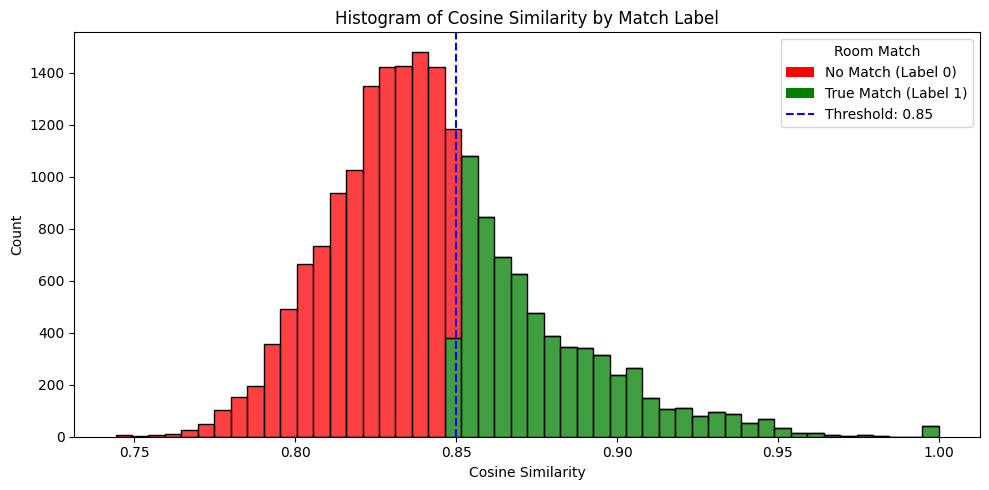

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Rename your dataframe to match_df if not already
# Assuming match_df contains: 'cosine_sim' and 'label'

# Plot histogram of cosine similarity by match label
plt.figure(figsize=(10, 5))
sns.histplot(
    data=match_df, 
    x='cosine_sim', 
    hue='label', 
    bins=50, 
    multiple='stack', 
    palette={0: 'red', 1: 'green'}, 
    stat='count'
)

# Add cosine similarity threshold line (0.85)
plt.axvline(0.85, color='blue', linestyle='--', label='Threshold: 0.85')

# Plot customization
plt.title("Histogram of Cosine Similarity by Match Label")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")

# Custom legend
legend_elements = [
    Patch(facecolor='red', label='No Match (Label 0)'),
    Patch(facecolor='green', label='True Match (Label 1)'),
    Line2D([0], [0], color='blue', linestyle='--', label='Threshold: 0.85')
]
plt.legend(handles=legend_elements, title="Room Match")

plt.tight_layout()
plt.show()


match_type
0.01.00.0    19527
Name: count, dtype: int64


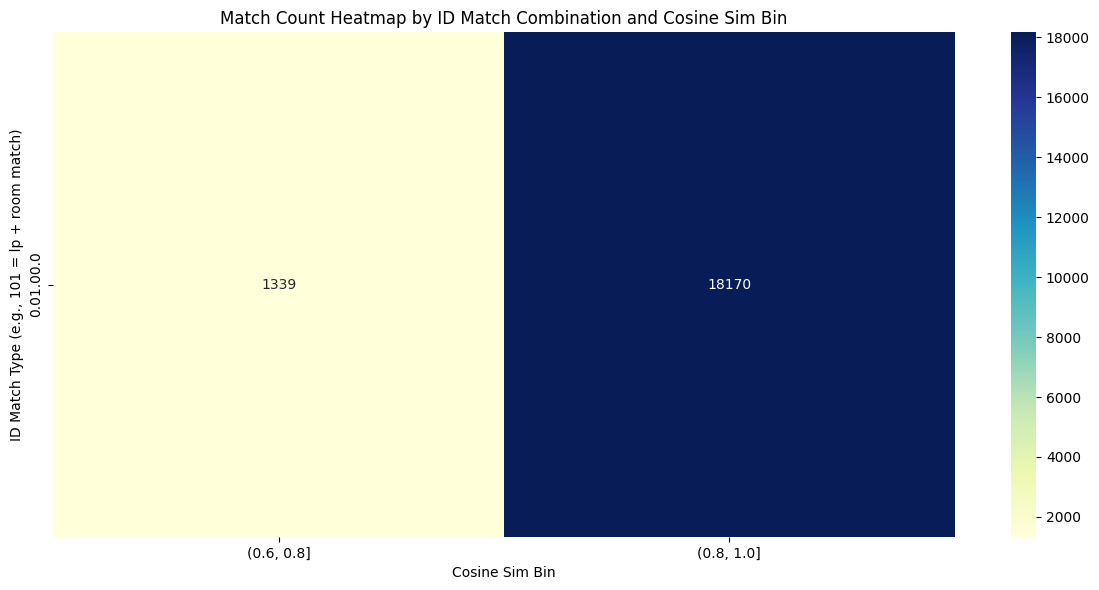

In [38]:
# Heatmap
# Make match_type a string like '100', '011', etc.
match_df['match_type'] = match_df.apply(
    lambda x: f"{x['lp_id_match']}{x['hotel_id_match']}{x['room_id_match']}", axis=1
)

# Count occurrences
match_type_counts = match_df['match_type'].value_counts().sort_index()
print(match_type_counts)

match_df['cos_bin'] = pd.cut(match_df['cosine_sim'], bins=np.linspace(0, 1, 6))
heatmap_data = match_df.groupby(['match_type', 'cos_bin'], observed=True).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Match Count Heatmap by ID Match Combination and Cosine Sim Bin")
plt.xlabel("Cosine Sim Bin")
plt.ylabel("ID Match Type (e.g., 101 = lp + room match)")
plt.tight_layout()
plt.show()


In [39]:

# Load match_df (simulating your data structure)

# Define features and target
#features = ['lp_id_match', 'hotel_id_match', 'room_id_match', 'fuzzy_score']
features = ['lp_id_match', 'hotel_id_match', 'room_id_match', 'cosine_sim']
target = 'label'

X = match_df[features]
y = match_df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Optuna objective
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return f1_score(y_test, preds)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Best model
best_params = study.best_params
best_params['eval_metric'] = 'logloss'
best_params['use_label_encoder'] = False

model = XGBClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(report_df.round(2))

# Save model
joblib.dump(model, '/kaggle/working/model.pkl')

[I 2025-04-25 15:12:00,057] A new study created in memory with name: no-name-45cdb0fd-7af1-4f7a-b80c-2c75c3744066
[I 2025-04-25 15:12:00,259] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.07649148269956262, 'max_depth': 4, 'n_estimators': 389, 'subsample': 0.648846995052395, 'colsample_bytree': 0.7700860430918732}. Best is trial 0 with value: 1.0.
[I 2025-04-25 15:12:00,423] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.018732827050465365, 'max_depth': 9, 'n_estimators': 369, 'subsample': 0.81912634187263, 'colsample_bytree': 0.5369520316918903}. Best is trial 0 with value: 1.0.
[I 2025-04-25 15:12:00,533] Trial 2 finished with value: 1.0 and parameters: {'learning_rate': 0.24925417924697327, 'max_depth': 6, 'n_estimators': 275, 'subsample': 0.9476319543760033, 'colsample_bytree': 0.9574960950586354}. Best is trial 0 with value: 1.0.
[I 2025-04-25 15:12:00,605] Trial 3 finished with value: 1.0 and parameters: {'learning_rate': 0.07709033479

              precision  recall  f1-score  support
0                   1.0     1.0       1.0   2551.0
1                   1.0     1.0       1.0   1355.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   3906.0
weighted avg        1.0     1.0       1.0   3906.0


['/kaggle/working/model.pkl']

#### fuzzy_score 0.75
                precision  recall  f1-score  support
    0                   1.0     1.0       1.0   3663.0
    1                   1.0     1.0       1.0    243.0
    accuracy            1.0     1.0       1.0      1.0
    macro avg           1.0     1.0       1.0   3906.0
    weighted avg        1.0     1.0       1.0   3906.0


#### fuzzy_score 0.85
               precision  recall  f1-score  support
    0                   1.0     1.0       1.0   3814.0
    1                   1.0     1.0       1.0     92.0
    accuracy            1.0     1.0       1.0      1.0
    macro avg           1.0     1.0       1.0   3906.0
    weighted avg        1.0     1.0       1.0   3906.0


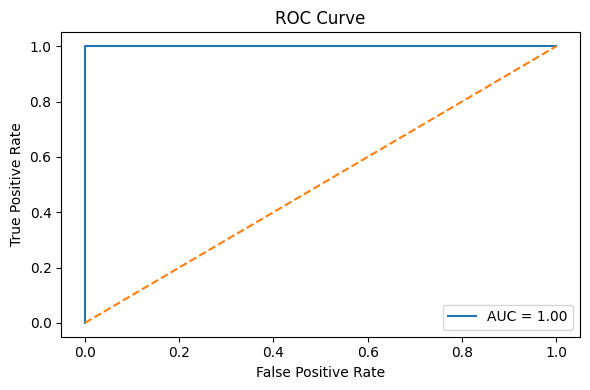

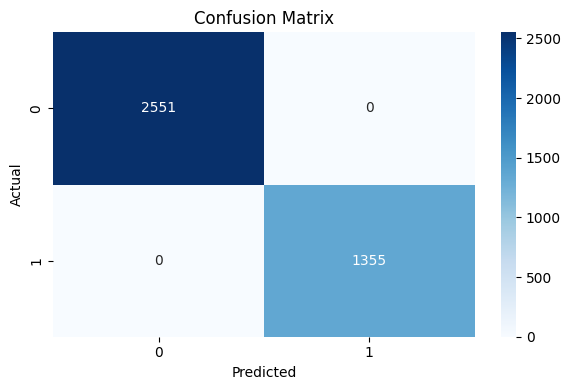

In [40]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [42]:
# Merge room names for better interpretability
match_df = match_df.merge(df_rooms[['core_room_id', 'supplier_room_id', 'supplier_room_name']], on=['core_room_id', 'supplier_room_id'], how='left')
match_df = match_df.merge(df_ref[['room_id', 'room_name']], left_on='ref_room_id', right_on='room_id', how='left')
match_df = match_df.rename(columns={'supplier_room_name': 'supplier_name', 'room_name': 'reference_name'})

# Show top matches and non-matches for human checking
sample_matches = match_df[(match_df['label'] == 1) & (match_df['cosine_sim'] > 0.85)].sample(3, random_state=42)
sample_non_matches = match_df[(match_df['label'] == 0) & (match_df['cosine_sim'] < 0.75)].sample(3, random_state=42)

tools.display_dataframe_to_user(name="Top Match Examples with Room Names", dataframe=sample_matches)
tools.display_dataframe_to_user(name="Top Non-Match Examples with Room Names", dataframe=sample_non_matches)

Top Match Examples with Room Names


Top Non-Match Examples with Room Names
